<a href="https://colab.research.google.com/github/AmirMansurian/Hemography-and-Essential-Matrix/blob/main/Essential_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error
from google.colab.patches import cv2_imshow
import imageio #for saving gif

function below calculates kronecker of correspondence points. it takes 8 3-d points in hemogenous coordinates and 8 correspondence and returns 8*9 matrix that each row represents kronecker of correspondec points. this function will be used in calculating essentail matrix.

In [52]:
def Kronecker(X, Y):
  res = np.zeros((8, 9))
  for i in range(8):
    res[i] = [X[i, 0]*Y[i, 0], X[i, 0]*Y[i, 1], X[i, 0]*Y[i, 2],
                       X[i, 1]*Y[i, 0], X[i, 1]*Y[i, 1], X[i, 1]*Y[i, 2], 
                       X[i, 2]*Y[i, 0], X[i, 2]*Y[i, 1], X[i, 2]*Y[i, 2]]
  return res

EssentialMtrix function takes 8 points and their correspondences and returns 3**3 Essential matrix. first of all it uses kronecker function to get kronecker matrix(A), then solution to problem will be eigenvector associated with smallest eigenvalue of matrix (At*A) called F. this solution will not be an essential matrix so we will find closest matrix with essential matrix constraints so svd decomposition of F is calculated in this function and smallest eigenvalue is set to zero and first and seconed eigenvalues are set to mean of these two eigenvalues and then reconstruct the F. this is the Essential matrix.

In [53]:
def EssentialMatrix (X, Y) : 
  A = Kronecker(X, Y)   # compute kronecker of correspondence points to get mattix A
  At = A.transpose()
  AtA = np.matmul(At, A)

  eigenValues, eigenVectors = np.linalg.eig(AtA)  # find eigenvector related to smallest eigenvalue
  idx = eigenValues.argsort()[::-1]  
  eigenValues = eigenValues[idx]
  eigenVectors = eigenVectors[:,idx]

  F = eigenVectors[8].reshape(3,3) #solution of X*E = 0 is F:
  U, Sigma, V = np.linalg.svd(F)

  S = np.zeros((3,3))
  S[0, 0] = S[1, 1] = (Sigma[0]+Sigma[1])/2 # constraints of essential matrix

  E = np.matmul((np.matmul(U, S)), V.transpose()) # reconstruct estimated Essential matrix
  return E

in this section for testing EssentialMatrix function we use two images below. first i have specified 8 point in left image and it's correspondeces in right image and calculated coordinates of these points. these point are in hemogenous coordinate. then it uses cv2 bult-in function to calculate the essential matrix of correspondence points and these essential matrixes will be compared with MSE parametr.
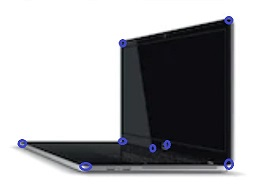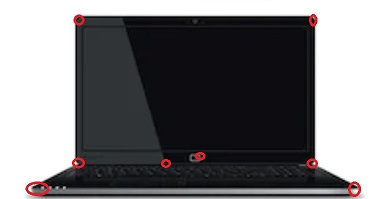

In [54]:
I4 = np.array([[83, 245, 1], [39, 461, 1], [284, 243, 1],[328, 459, 1],   # points of right image in hemegenous coordinates
              [331, 166, 1], [286, 47, 1], [291, 332, 1],[296, 303, 1]])
I5 = np.array([[36, 155, 1], [34, 625, 1], [329, 158, 1],[323, 627, 1],   # points of left image in hemegenous coordinates
              [375, 714, 1], [375, 67, 1], [313, 398, 1],[327, 331, 1]])

E = EssentialMatrix(I4, I5) # calculate essential matrix implemented in previous section

p1 = np.array([[83, 245], [39, 461], [284, 243],[328, 459],   # points of right image in 2D coordinates
              [331, 166], [286, 47], [291, 332],[296, 303]])
p2 = np.array([[36, 155], [34, 625], [329, 158],[323, 627],   # points of right image in 2D coordinates
              [375, 714], [375, 67], [313, 398],[327, 331]])

e, mask = cv2.findEssentialMat(p1, p2, method=cv2.FM_8POINT)  #calculate essential matrix with CV2 package built-in function
#f, mask = cv2.findFundamentalMat(p1, p2, method=cv2.FM_8POINT)

print('Essential matrix calculated with implemented function:\n', E, '\n \n', 'Essential matrix calculated with CV2 package:\n', e)
print(f'\n MSE of Essential matrixes = {mean_squared_error(E,e) }')

Essential matrix calculated with implemented function:
 [[-1.75616268e-06 -2.00026869e-04 -4.72514832e-06]
 [ 4.38732070e-03  5.01516776e-01  3.65259688e-04]
 [-6.87474037e-04  3.71289268e-04 -5.01535530e-01]] 
 
 Essential matrix calculated with CV2 package:
 [[-7.52734484e-04 -3.21844764e-04 -3.58708837e-01]
 [ 1.82098191e-03  1.28860714e-05 -6.09365684e-01]
 [ 6.95854047e-01  1.25631561e-01  1.14149591e-03]]

 MSE of Essential matrixes = 0.16727757760787706


in last section we calculated Essential matrix with our own function and CV2 built-in function. now we decompose this matrixes to get Rotatoin and Translation matrixes from essential matrixes and compare results. when we decompose essential matrix to get Translation matrix mannualy , we have two options for Rotation and Translation matrixes. Translation matrix with negative element is not accepetable because it is located behined the camera so we choose Translation matrix with positive elements. so we will get two pair of R,T matrixes as a result:

In [55]:
W1 = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]) # rotation matrix of Z axie  with theta = 90 degrees
W2 = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]]) # rotation matrix of Z axie  with theta = -90 degrees

U, Sigma, V = np.linalg.svd(E)  #svd decomposition of Essential matrix
S = np.diag(Sigma)

# in below lines twisted pair of results are calculated
That1 = np.matmul(np.matmul(np.matmul(U, W1), S), U.transpose())  
R1 = np.matmul(np.matmul(U, W1.transpose()), V.transpose())

That2 = np.matmul(np.matmul(np.matmul(U, W2), S), U.transpose())
R2 = np.matmul(np.matmul(U, W2.transpose()), V.transpose())

T1 = np.array([That1[2,1], That1[0, 2], That1[1,0]])  # accepted T matrix = [5, 0, 0]
T2 = np.array([That2[2,1], That2[0, 2], That2[1,0]])  #unaccepable Translation matrix = [-5, 0, 0]

print('Rotatoin matrix 1 decomposed from Essential matrix from our own function : \n', R1, '\n\n', 'Translation matrix 1 decomposed from Essential matrix from our own function : \n', T1, '\n')
print('Rotatoin matrix 2 decomposed from Essential matrix from our own function : \n', R2, '\n\n', 'Translation matrix 2 decomposed from Essential matrix from our own function : \n', T2, '\n')

R12, r12, T12 = cv2.decomposeEssentialMat(E)  #Decompose Essential matrix with CV2 package

print('Rotatoin matrix 1 decomposed from Essential matrix from CV2 package\n', R12, '\n\n', 'Rotatoin matrix 2 decomposed from Essential matrix from CV2 package\n', r12, '\n')
print('Translation matrix decomposed from Essential matrix from CV2 package : \n', T12)

Rotatoin matrix 1 decomposed from Essential matrix from our own function : 
 [[-0.98783897 -0.15547036 -0.00177214]
 [ 0.02368339 -0.16172656  0.98655138]
 [ 0.15366609 -0.97451192 -0.16344186]] 

 Translation matrix 1 decomposed from Essential matrix from our own function : 
 [ 5.01536099e-01  2.00037966e-04 -4.57946948e-06] 

Rotatoin matrix 2 decomposed from Essential matrix from our own function : 
 [[-9.87822568e-01 -1.55581519e-01 -9.82180696e-04]
 [-2.44713877e-02  1.61602497e-01 -9.86552474e-01]
 [-1.53648055e-01  9.74514763e-01  1.63441889e-01]] 

 Translation matrix 2 decomposed from Essential matrix from our own function : 
 [-5.01536099e-01 -2.00037966e-04  4.57946948e-06] 

Rotatoin matrix 1 decomposed from Essential matrix from CV2 package
 [[-9.99960252e-01  8.73733114e-03  1.77600330e-03]
 [-1.76957163e-03  7.43789065e-04 -9.99998158e-01]
 [-8.73863602e-03 -9.99961552e-01 -7.28298167e-04]] 

 Rotatoin matrix 2 decomposed from Essential matrix from CV2 package
 [[-9.9996

in this section we are going to to calculate Homograpghy matrix between left image below and bilboard in the right image. for hemography matrix we need 4 correspondence point . i have choosed 4 corners of the bilboard. we want to project left image to the bilboard in the right image so corresponde corners of left image with corners of bilboard in the right image and calculate Hemography matrix with CV2 package. then we calculate projected location of the left image in the right image and print the left image in th bilboard .

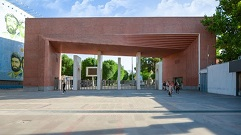
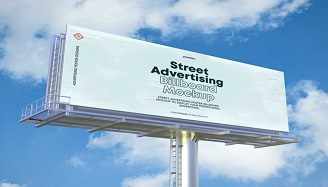

Hemography matrix : 
 [[ 5.22289004e-01  2.94432971e-01  9.80000000e+01]
 [-8.33764758e-02  1.27715450e+00  2.70000000e+02]
 [-1.15059975e-04  3.35841156e-04  1.00000000e+00]]


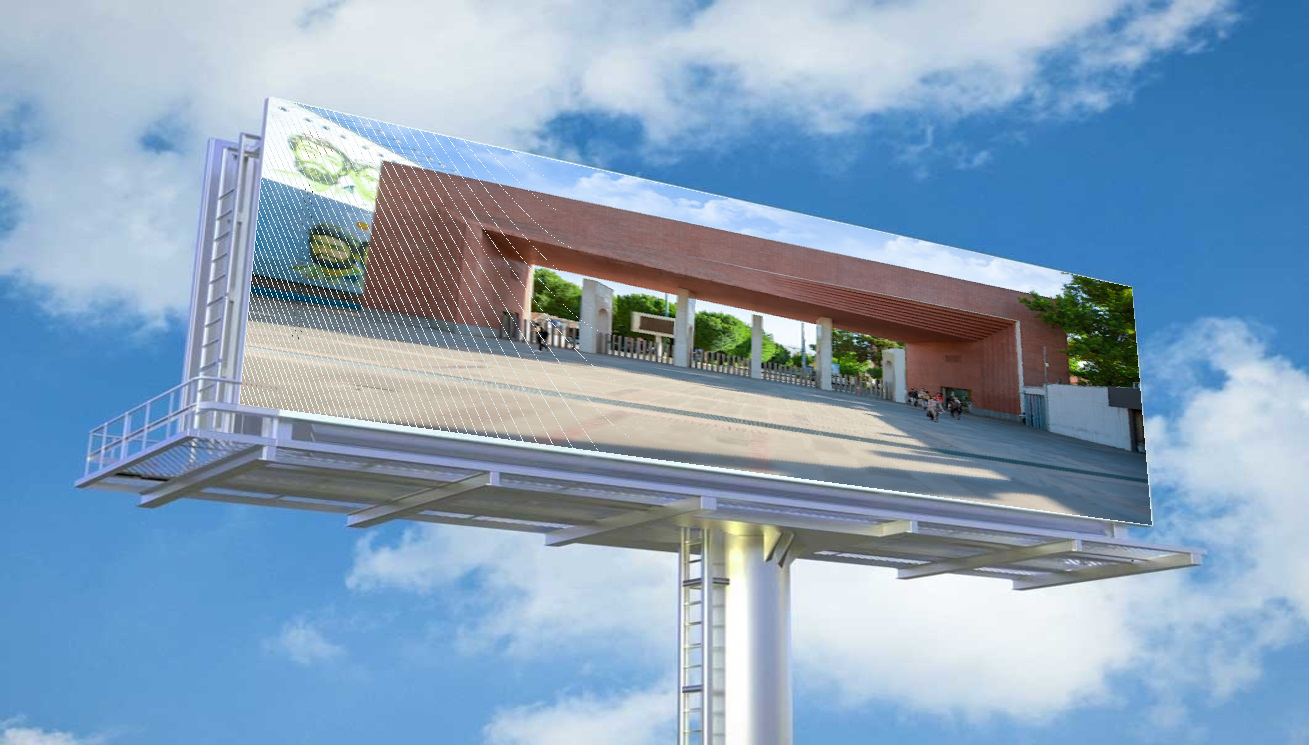

In [57]:
I1 = np.array([[0, 0], [0, 961], [538, 0],[538, 961]])   # corners of left image
I2 = np.array([[98, 270], [288, 1132], [404, 240],[525, 1152]])   # corners of bilboard in right image

H, s = cv2.findHomography(I1, I2) # calculate Hemography matrix with CV2 package
print('Hemography matrix : \n', H)

image1 = cv2.imread('image1.jpg')
image2 = cv2.imread('image2.jpg')

Row, Col, Dim = image1.shape

for i in range(Row):
  for j in range(Col):
    temp = np.array([i, j, 1])
    row, col, dim = np.matmul(H, temp.transpose())  # project each pixel of left image on the bilboard by hemography matrix
    row = int(row/dim)
    col = int(col/dim)
    image2[row, col] = image1[i, j] 
cv2_imshow(image2)

at last we project gif file image3.gif to bilboard and create and save a new gif with playing image3.gif in the bilboard:

In [58]:
I1 = np.array([[0, 0], [0, 961], [538, 0],[538, 961]])   # corners of the gif 
I2 = np.array([[98, 270], [288, 1132], [404, 240],[525, 1152]])   # corners of the bilboard in right image
H, s = cv2.findHomography(I1, I2) # calculate Hemography matrix with CV2 package

gif = cv2.VideoCapture('image3.gif')
image2 = cv2.imread('image2.jpg')

frameNo = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))  # number of frames in gif file
Frames = []

for f in range(frameNo):
  ret, image = gif.read() # read frames of gif

  for i in range(538):
    for j in range(961):
      temp = np.array([i, j, 1])
      row, col, dim = np.matmul(H, temp.transpose())  # project each pixel of frames of gif on the bilboard
      row = int(row/dim)
      col = int(col/dim)
      image2[row, col] = image[i, j]  
  
  Frames.append(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)) # append created frame to new gif file

with imageio.get_writer("bilboard.gif", mode="I") as writer:  # save new gif file
    for idx, frame in enumerate(Frames):
        writer.append_data(frame)